## Part 1 - Exploratory data analysis
##### The attached logins.json file contains (simulated) timestamps of user logins in a particular geographic location. Aggregate these login counts based on 15 minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. Please report/illustrate important features of the demand, such as daily cycles. If there are data quality issues, please report them.

In [73]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest,chi2
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix,roc_curve, auc,classification_report, precision_score, recall_score, f1_score
import time


#functions
###########################################################################################
def prepare_train_test (df,target):
    X = df.drop(target, axis = 1)
    y = df[[target]]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
    return X_train, X_test, y_train, y_test
    
def select_features(X_train, y_train, X_test):
    fs = SelectKBest(score_func=chi2, k='all')
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

    # data prepration
def prepare_train_test (df,target):
    X = df.drop(target, axis = 1)
    y = df[[target]]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
    return X_train, X_test, y_train, y_test

# feature selection
def calculate_scores(fs,features):
    features_score = []
    for i in range(len(fs.scores_)):
        features_score.append((features.columns.values[i],fs.scores_[i]))
    # plot the scores
    features_score.sort(key=lambda y: y[1], reverse = True)
    df_scores = pd.DataFrame(features_score, columns =['Name', 'Score'])
    print(df_scores)
    plt.bar([i for i in range(len(df_scores))],df_scores['Score'])
    plt.xticks(rotation=20)
    plt.show() 
def plot_auc(labels, probs,model_name):
    ## Compute the false positive rate, true positive rate
    ## and threshold along with the AUC
    fpr, tpr, threshold = roc_curve(labels, probs[:,1])
    AUC = auc(fpr, tpr)
    
    ## Plot the result
    plt.title(model_name + ' ROC')
    plt.plot(fpr, tpr, color = 'orange', label = 'AUC = %0.2f' % AUC)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
def apply_mode(X_train,y_train,X_test,y_test,model,model_name):
    model = model
    tic1 = time.perf_counter()
    model.fit(X_train, y_train.values.ravel())
    toc1 = time.perf_counter()
    tic2 = time.perf_counter()
    y_pred = model.predict(X_test)
    toc2 = time.perf_counter()
    y_pred_prob = model.predict_proba(X_test)
    cm = confusion_matrix(y_test, y_pred)


    model_acc = model.score(X_test,y_test.values.ravel())
    model_precision_score = precision_score(y_test,y_pred)
    model_recall_score = recall_score(y_test,y_pred)
    model_f1_score = f1_score(y_test,y_pred,average = 'weighted')

    print('Confusion Matrix for: {}'.format(model_name))
    print(cm)
    print(classification_report(y_test,y_pred))
    print('Total elapsed time to fit is: {:0.4f} (s)'.format(toc1 - tic1))
    print('Total elapsed time to predict is: {:0.4f} (s)'.format(toc2 - tic2))
    print('Overal elapsed time to predict is: {:0.4f} (s)'.format(toc2 - tic1))
    plot_auc(y_test, y_pred_prob,model_name) 
    return(model_acc,model_f1_score,model_precision_score,model_recall_score)
 
 
def apply_gridSearch(model,param_grid,X,y,model_name):
    
     model_cv= GridSearchCV(model,param_grid,cv=5,refit=True)
     tic = time.perf_counter()
     model_cv.fit(X,y.values.ravel())
     toc = time.perf_counter()
     
     print ('The best score for the search grid for {} is {:2.2f} '.format(model_name,model_cv.best_score_))
     print('The best parameters for the search grid for {} is {} '.format(model_name,model_cv.best_params_))
     print('Total elapsed time is: {:0.4f} (s)'.format(toc - tic))     


def plot_feature_importance(model, model_name, features):
    feature_importance = model.feature_importances_
    sorted_idx = np.argsort(feature_importance)

    pos = np.arange(sorted_idx.shape[0]) + .5
    plt.figure(figsize=(20,10))
    plt.barh(pos, feature_importance[sorted_idx], align='center')
    plt.yticks(pos, features.columns[sorted_idx])
    plt.xlabel('Relative Importance')
    plt.title('{} - Feature Importance'.format(model_name))
    plt.show()    

    

In [7]:
data = pd.read_json('logins.json')


In [8]:
data.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [10]:
data.set_index('login_time', inplace=True)

In [11]:
data

""
login_time
1970-01-01 20:13:18
1970-01-01 20:16:10
1970-01-01 20:16:37
1970-01-01 20:16:36
1970-01-01 20:26:21
...
1970-04-13 18:50:19
1970-04-13 18:43:56
1970-04-13 18:54:02


In [12]:
data['count'] = 1

In [13]:
data

,count
login_time,
1970-01-01 20:13:18,1
1970-01-01 20:16:10,1
1970-01-01 20:16:37,1
1970-01-01 20:16:36,1
1970-01-01 20:26:21,1
...,...
1970-04-13 18:50:19,1
1970-04-13 18:43:56,1
1970-04-13 18:54:02,1


In [14]:
data_15min = data.resample('15T', label='right').sum()

In [15]:
data_15min.head(5)

,count
login_time,
1970-01-01 20:15:00,2
1970-01-01 20:30:00,6
1970-01-01 20:45:00,9
1970-01-01 21:00:00,7
1970-01-01 21:15:00,1


In [16]:
data_15min.describe()

,count
count,9788.000000
mean,9.515938
std,8.328818
min,0.000000
25%,3.000000
50%,7.000000
75%,13.000000
max,73.000000


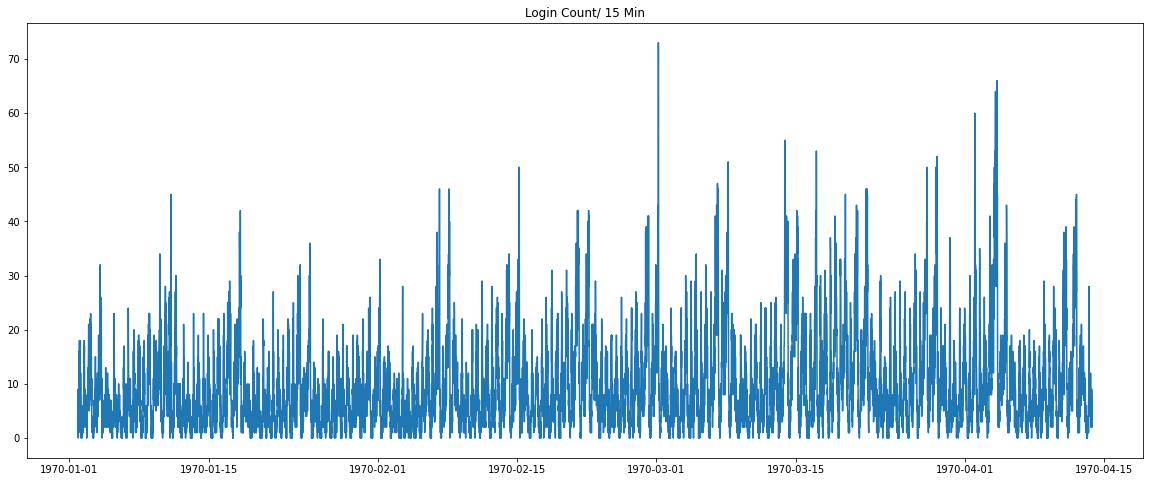

In [17]:
plt.figure(figsize=(20,8))
plt.title('Login Count/ 15 Min')
plt.plot(data_15min)


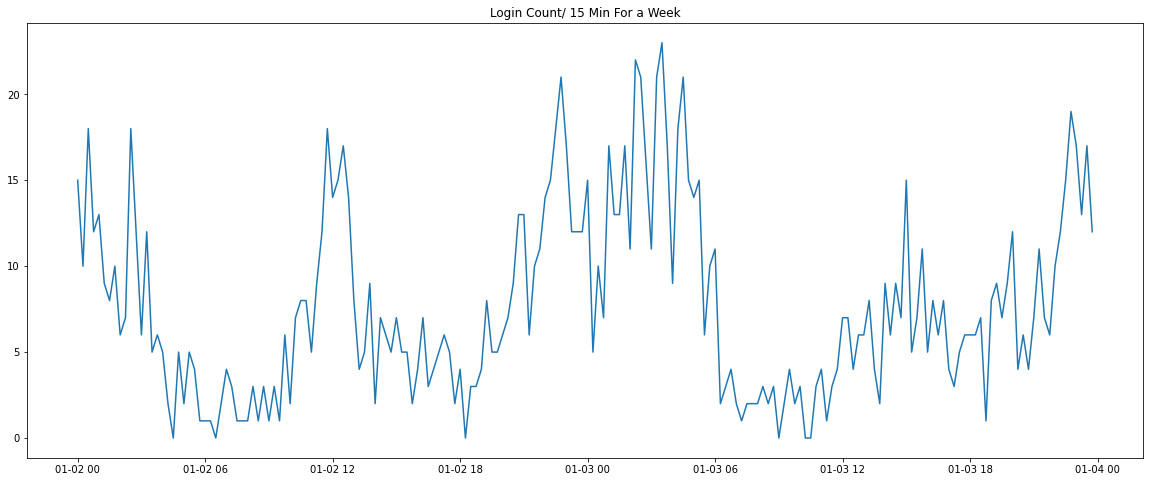

In [18]:
plt.figure(figsize=(20,8))
plt.title('Login Count/ 15 Min For a Week')
plt.plot(data_15min['1970-01-02':'1970-01-03'])


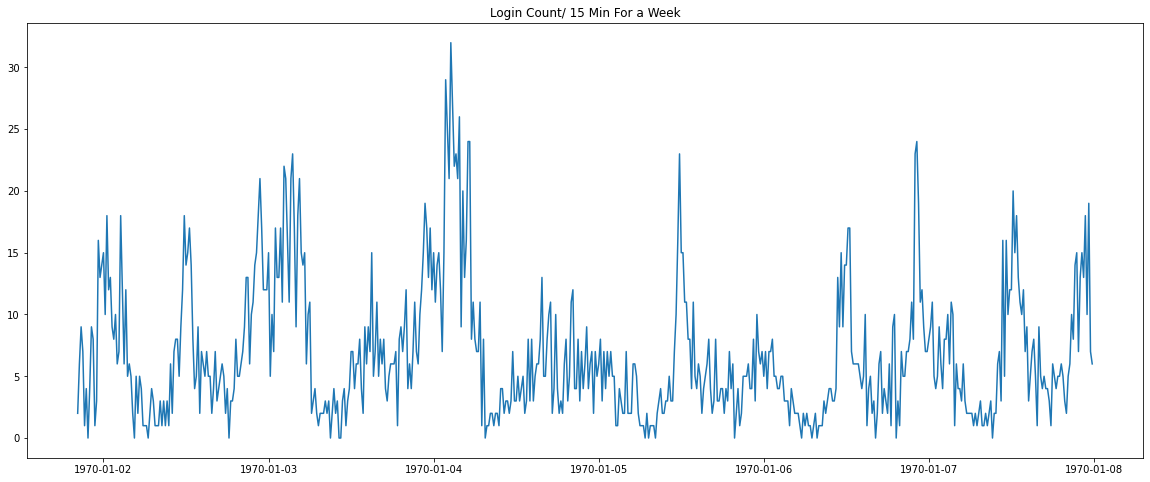

In [19]:
plt.figure(figsize=(20,8))
plt.title('Login Count/ 15 Min For a Week')
plt.plot(data_15min['1970-01-01':'1970-01-07'])

In [20]:
data_15min['time'] = data_15min.index.time
data_15min['month'] = data_15min.index.month_name()
data_15min['day'] = data_15min.index.day_name()
data_15min['hour'] = data_15min.index.hour

<AxesSubplot:title={'center':'hourly login count/ 15 min'}, xlabel='hour', ylabel='Count'>

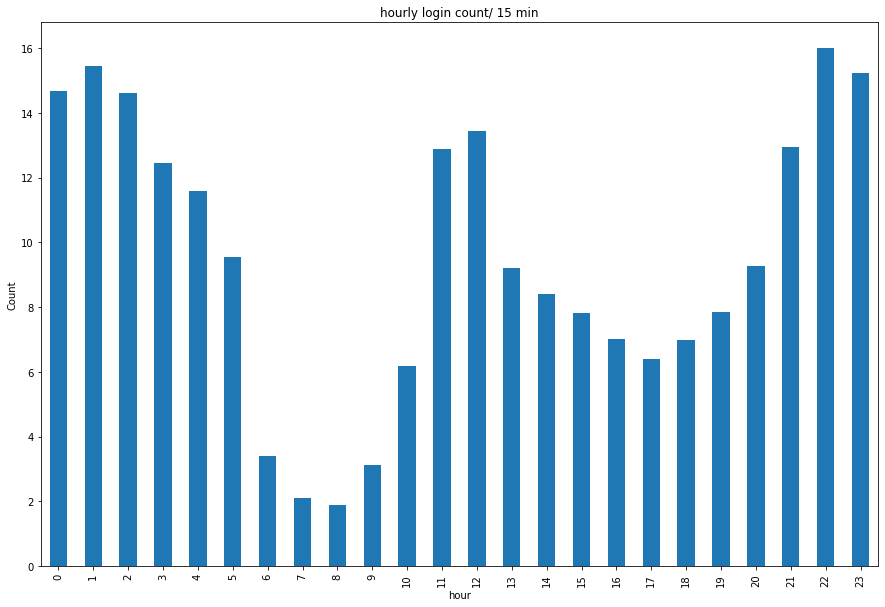

In [21]:
hourly_grouped = data_15min.groupby(['hour'])['count'].mean()
fig, ax = plt.subplots(figsize=(15,10))
ax.set_ylabel('Count')
ax.set_title('hourly login count/ 15 min')
hourly_grouped.plot(kind ='bar')

In [22]:
data_15min.head()

,count,time,month,day,hour
login_time,,,,,
1970-01-01 20:15:00,2,20:15:00,January,Thursday,20
1970-01-01 20:30:00,6,20:30:00,January,Thursday,20
1970-01-01 20:45:00,9,20:45:00,January,Thursday,20
1970-01-01 21:00:00,7,21:00:00,January,Thursday,21
1970-01-01 21:15:00,1,21:15:00,January,Thursday,21


<AxesSubplot:title={'center':'Week Day login count/ 15 min'}, xlabel='day', ylabel='Count'>

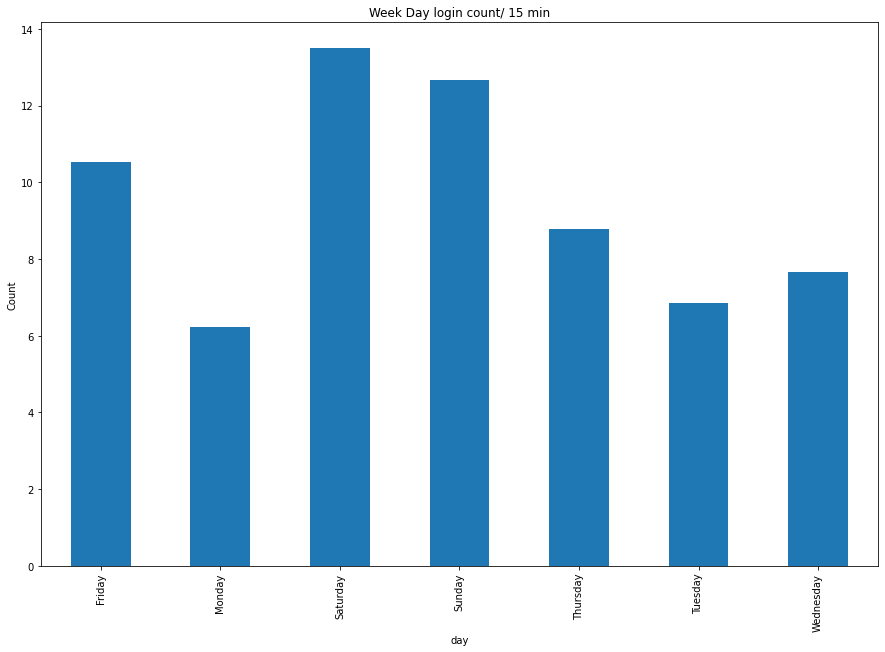

In [23]:
daily_grouped = data_15min.groupby(['day'])['count'].mean()
fig, ax = plt.subplots(figsize=(15,10))
ax.set_ylabel('Count')
ax.set_title('Week Day login count/ 15 min')
daily_grouped.plot(kind ='bar')

<AxesSubplot:xlabel='day', ylabel='count'>

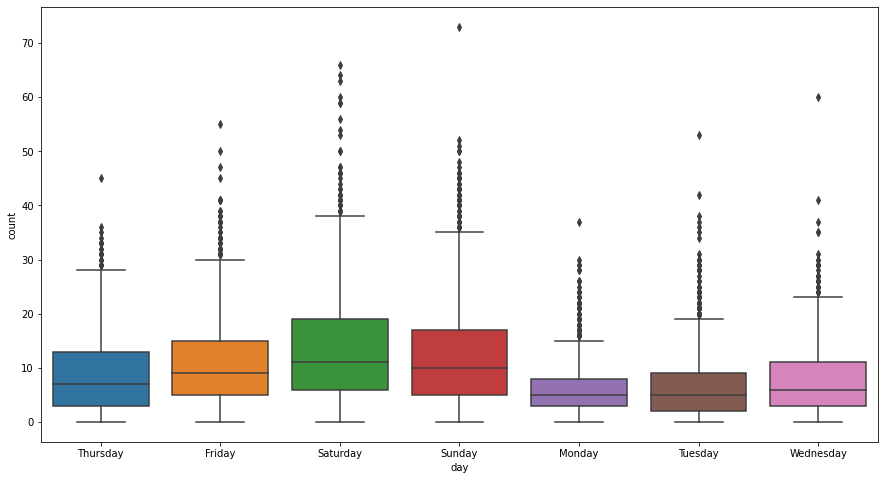

In [24]:
plt.figure(figsize=(15,8))
sns.boxplot(data=data_15min, x='day', y='count')

## Conclusion:

- Daily: 
As seen in the graphs, specially in the hourly plot, the lowest amoung of logins happens in early mornings(5-10). After the numbers increase till 12 o clock. Afternoon again the numbers decreas till 5pm and start to increase to get the peek at midnight.

- Weekly:
The number of logins are the highest during the weekends, specially Saturdays. Mondays have the lowest amount of logins.

## Part 2 ‐ Experiment and metrics design

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.

### Question-1

1) What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?

### Answer-1

1) As mentioned in the problem context, because of the toll fees, drivers tend to stay in one city, therefore if demand is higher in the opposit city, drivers will miss the chance to give service. Therefore the best success measure key is the is to increase the number of drivers rides per day. Which means, the metric is the mean of overal rides count per day. If the number of rides increases, it will indicates, they are offering more services, which will be in indication of them passing the bridge for some of the rides, and eventually more profit for the company, and more prfit for drivers also more satisfaction for the customers.

### Question-2

2) Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:
* a) how you will implement the experiment
* b) what statistical test(s) you will conduct to verify the significance of the observation
* c) how you would interpret the results and provide recommendations to the city operations team along with any caveats.


### Answer-2

2-a)
- If we already have data for the pas rides, it means we have data for our population. We will select a sample size( randomly - independet(eithere sampling with replacement or the sample size should be less than 10%)- normal distrbutaion n > 30), and will repeat the experiment for 30 days. We dont want to make the company wait so long for the result and also we want to have enought data for all the weekdays. We will reimburse the toll for the sample drivers. For example we will select 1000 drivers and calculate the number of the rides for each per day and will calculate the overal mean and standard deviation for the sample size. 
For the population we also will calculate the ride counts for a month and calculate the mean for the data.

** Note:
If we dont have data for the ride counts for last months, we should do A/B testing. One group for control and one group for test.

2-b)
- we will conduct a t-test or z-test for observation. So we will calculate the p-value of occurance of our test results unders the null hypothesis condition and compare the value to the significance level, to accept or reject the null hypothesis respectly.  

2-c)
- To interpret the result correclty, we have to set our confidence level befor starting the test. That means how flexible are we to accept the false positives. Usually statistical significance of 95% is an acceptable number with alpha = 0.05
Therefore if the calculated p-values lies below alpha we will reject the null hypothesis with is there was no increase in the number of rides.
According to the result (p-value), we can suggest that toll reimbursment can increase the overal number of rides. Still we have to consider other costs too. For example we should compare the toll reimbursment cost with the increase in rides number to calculate the actual profit. If after all the calculation we still see in benefit of this experiment, for sure we will recommend, to do this reimbursment for all the drivers.


## Part 3 ‐ Predictive modeling

## 3-1) Data Cleaning - EDA

In [25]:
users_data = pd.read_json('ultimate_data_challenge.json', convert_dates=['signup_date','last_trip_date'])

In [26]:
users_data.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [27]:
users_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    41878 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   49604 non-null  object        
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  bool          
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    49799 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(6), int

In [28]:
users_data.avg_rating_of_driver.fillna(0,inplace=True)
users_data.avg_rating_by_driver.fillna(0,inplace=True)
users_data.isnull().sum()

city                        0
trips_in_first_30_days      0
signup_date                 0
avg_rating_of_driver        0
avg_surge                   0
last_trip_date              0
phone                     396
surge_pct                   0
ultimate_black_user         0
weekday_pct                 0
avg_dist                    0
avg_rating_by_driver        0
dtype: int64

In [29]:
users_data.phone.isnull().sum()

396

We can drop the rows( the amount is very lttile comparing to all the 50K)
or fill the null with string 'Unknown' 

In [30]:
users_data.phone.fillna('unknown',inplace=True)
users_data.phone.value_counts()

iPhone     34582
Android    15022
unknown      396
Name: phone, dtype: int64

In [31]:
users_data['last_trip_date'].describe()

/var/folders/pm/804wbvdx4lz30mqcr3mys38r0000gn/T/ipykernel_50528/1884088541.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  users_data['last_trip_date'].describe()


count                   50000
unique                    182
top       2014-06-29 00:00:00
freq                     2036
first     2014-01-01 00:00:00
last      2014-07-01 00:00:00
Name: last_trip_date, dtype: object

In [32]:
# the last date for the collected date is 2014-07-01
# if the user last activity date lies in 30 days befor July we consider that as an active user
end_date = datetime.datetime(2014, 7, 1)
users_data['active'] = (( end_date - users_data['last_trip_date']).dt.days < 30).astype(int)

In [33]:
# number of active users
users_data['active'].sum()

18310

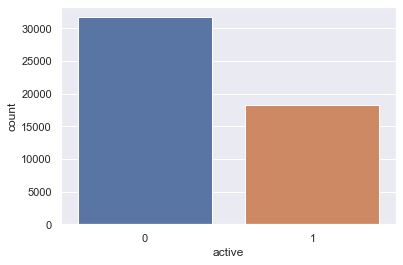

In [34]:
#plot the number of active and deactive users
sns.set_theme(style="darkgrid")
sns.countplot(x = 'active',data = users_data);

In [35]:
active_deactive_grouped = users_data.groupby(['active'])['active'].count()
active_deactive_grouped

active
0    31690
1    18310
Name: active, dtype: int64

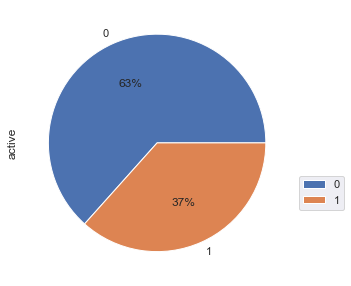

In [36]:
# plot the percentage of users being active and deactive
fig, ax = plt.subplots(figsize=(15,5))
active_deactive_grouped.plot(kind ='pie',ax=ax ,autopct='%1.0f%%')
plt.legend(loc="upper left",bbox_to_anchor=(1,0.4))

As seen above 36% are still active and 64% did not use the application recently.

In [37]:
users_data['city'].value_counts()

Winterfell        23336
Astapor           16534
King's Landing    10130
Name: city, dtype: int64

In [38]:
users_data.phone.value_counts()

iPhone     34582
Android    15022
unknown      396
Name: phone, dtype: int64

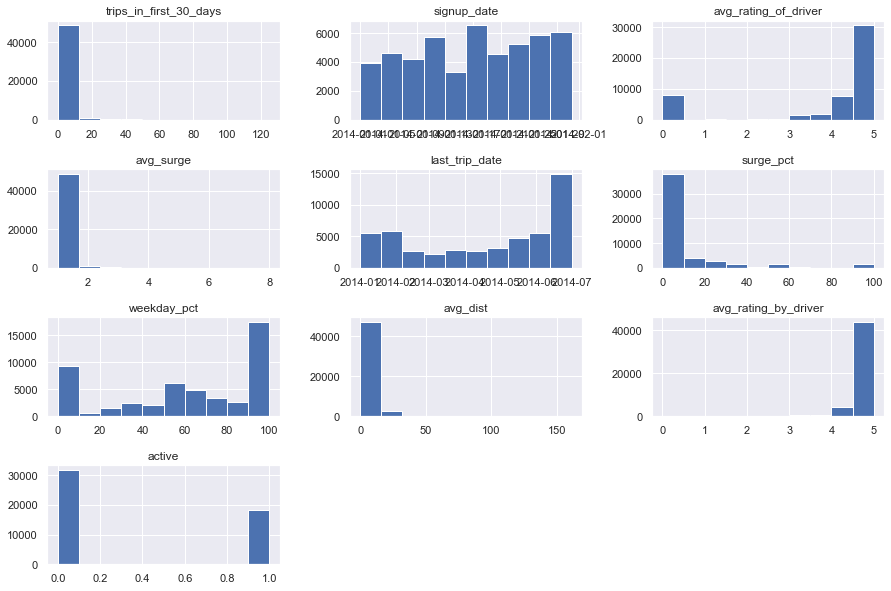

In [39]:
users_data.hist(figsize=(15,10))
plt.subplots_adjust(hspace=0.5);

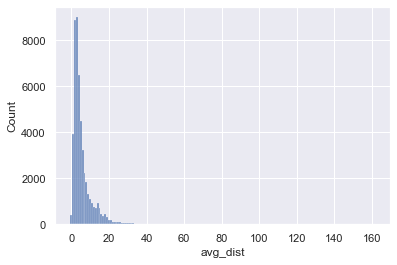

In [40]:
sns.set_theme(style="darkgrid")
sns.histplot(x= 'avg_dist',data = users_data,discrete=True);

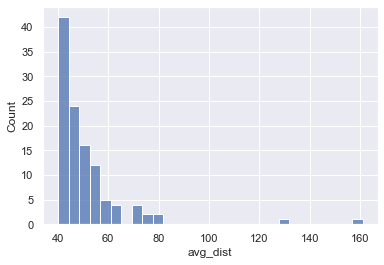

In [41]:
longer_distance = users_data[users_data.avg_dist > 40]
sns.histplot(x= 'avg_dist',data = longer_distance);

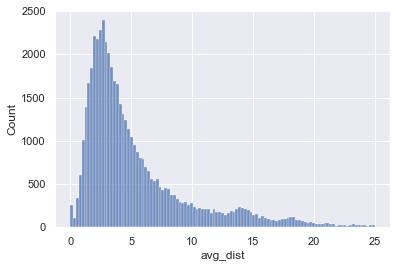

In [42]:
shorter_distance = users_data[users_data.avg_dist < 25]
sns.histplot(x= 'avg_dist',data = shorter_distance);

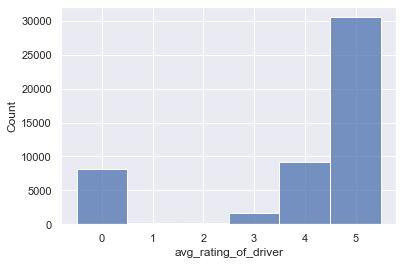

In [43]:
#plot the distbution of user rating
sns.set_theme(style="darkgrid")
sns.histplot( x= 'avg_rating_of_driver',data = users_data,discrete=True);

In [44]:
# get the null value
users_data['avg_rating_of_driver'].isnull().sum()

0

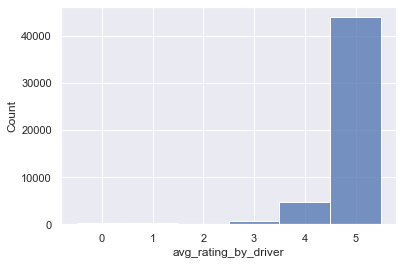

In [45]:
#plot the distbution of user rating
sns.set_theme(style="darkgrid")
sns.histplot( x= 'avg_rating_by_driver',data = users_data,discrete=True);

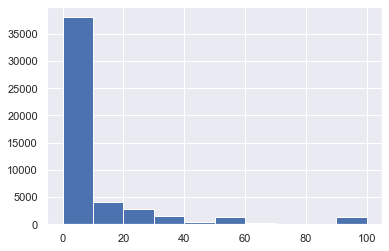

In [46]:
plt.hist(users_data['surge_pct']);

<AxesSubplot:xlabel='trips_in_first_30_days'>

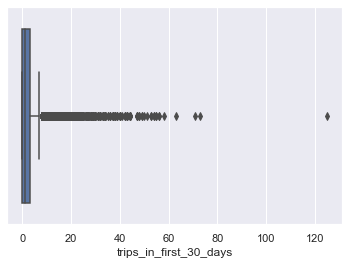

In [47]:
sns.boxplot(x = 'trips_in_first_30_days',data=users_data)

In [48]:
users_data = users_data[users_data['trips_in_first_30_days'] < 15]

<AxesSubplot:xlabel='trips_in_first_30_days'>

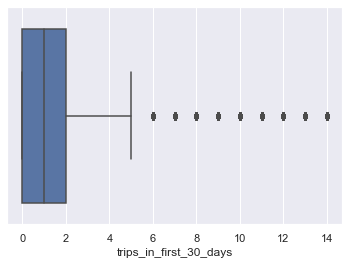

In [49]:
sns.boxplot(x = 'trips_in_first_30_days',data=users_data)

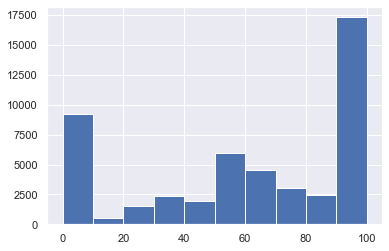

In [50]:
plt.hist(users_data['weekday_pct']);

In [51]:
# deactive user by phone
phone_grouped = users_data.groupby(['phone','active'])['active'].count()

In [52]:
phone_grouped

phone    active
Android  0         12004
         1          2832
iPhone   0         19191
         1         14651
unknown  0           265
         1           122
Name: active, dtype: int64

/Users/nakisaabbasi/opt/anaconda3/lib/python3.9/site-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_obj.generate()


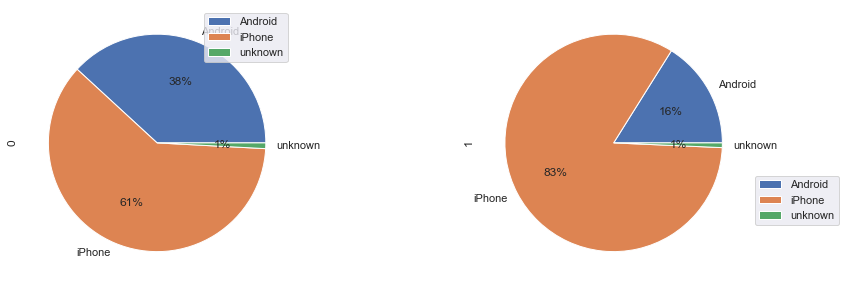

In [53]:
#active-deactive users based on phone
fig, ax = plt.subplots(figsize=(15,5))
phone_grouped.unstack().plot(kind ='pie',ax=ax ,autopct='%1.0f%%',subplots=True)
plt.legend(loc="upper left",bbox_to_anchor=(1,0.4))

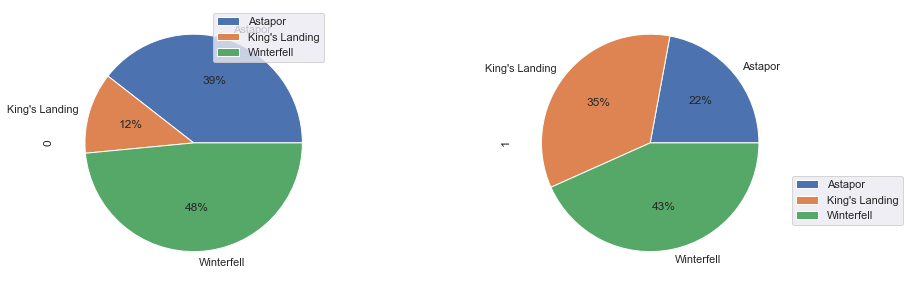

In [54]:
#active-deactive users based on city
city_grouped = users_data.groupby(['city','active'])['active'].count()
fig, ax = plt.subplots(figsize=(15,5))
city_grouped.unstack().plot(kind ='pie',ax=ax ,autopct='%1.0f%%',subplots=True)
plt.legend(loc="upper left",bbox_to_anchor=(1,0.4))

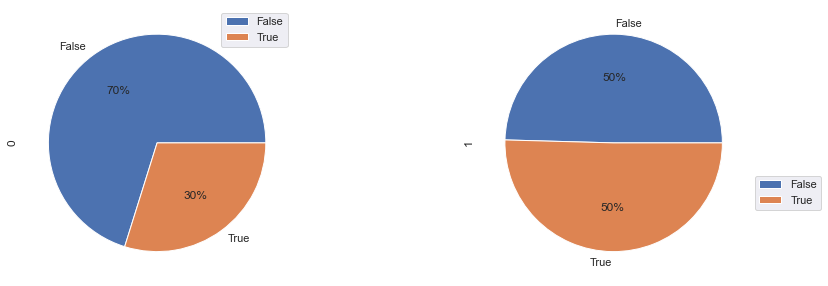

In [55]:
#active-deactive users based on being ultimate user
ultimate_grouped = users_data.groupby(['ultimate_black_user','active'])['active'].count()
fig, ax = plt.subplots(figsize=(15,5))
ultimate_grouped.unstack().plot(kind ='pie',ax=ax ,autopct='%1.0f%%',subplots=True)
plt.legend(loc="upper left",bbox_to_anchor=(1,0.4))

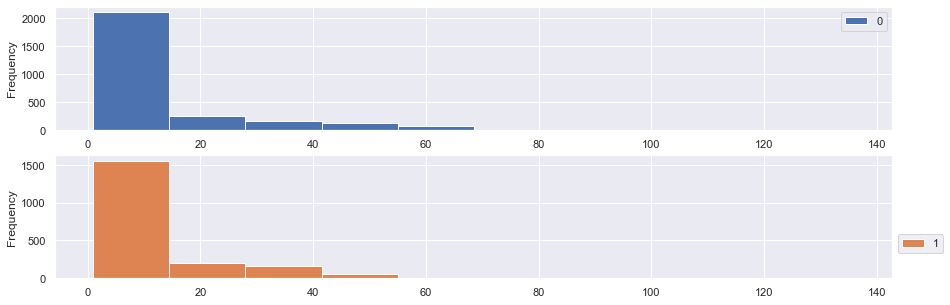

In [56]:
#active-deactive users based on avg_dist
avrg_dis_grouped = users_data.groupby(['avg_dist','active'])['active'].count()

fig, ax = plt.subplots(figsize=(15,5))
avrg_dis_grouped.unstack().plot(kind ='hist',ax=ax ,subplots=True)
plt.legend(loc="upper left",bbox_to_anchor=(1,0.4))

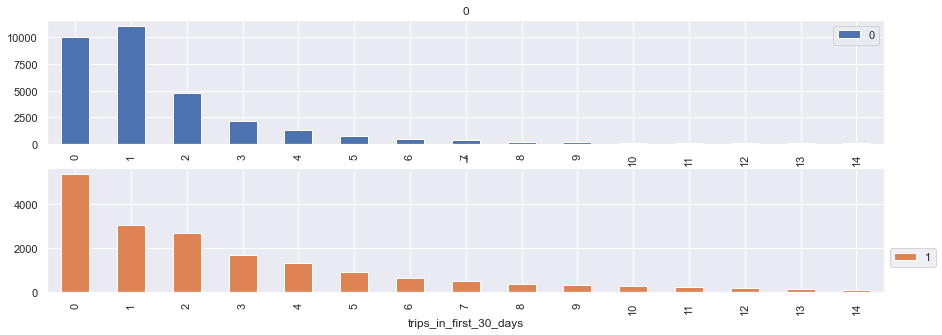

In [57]:
#active-deactive users based on being number of trips in therie first days
trips_in_first_30_days_grouped = users_data.groupby(['trips_in_first_30_days','active'])['active'].count()

fig, ax = plt.subplots(figsize=(15,5))
trips_in_first_30_days_grouped.unstack().plot(kind ='bar',ax=ax ,subplots=True)
plt.legend(loc="upper left",bbox_to_anchor=(1,0.4))

## 3-2) Preprocessing - Modeling

In [58]:
#Lets drop dates object
users_data = users_data.drop(['signup_date','last_trip_date'],axis=1)

#convert categorical to numeric and drop the first colum to avoid multicollinearity
users_data_numeric = pd.get_dummies(users_data,drop_first=True)
users_data_numeric.ultimate_black_user = users_data_numeric.ultimate_black_user.astype(int)

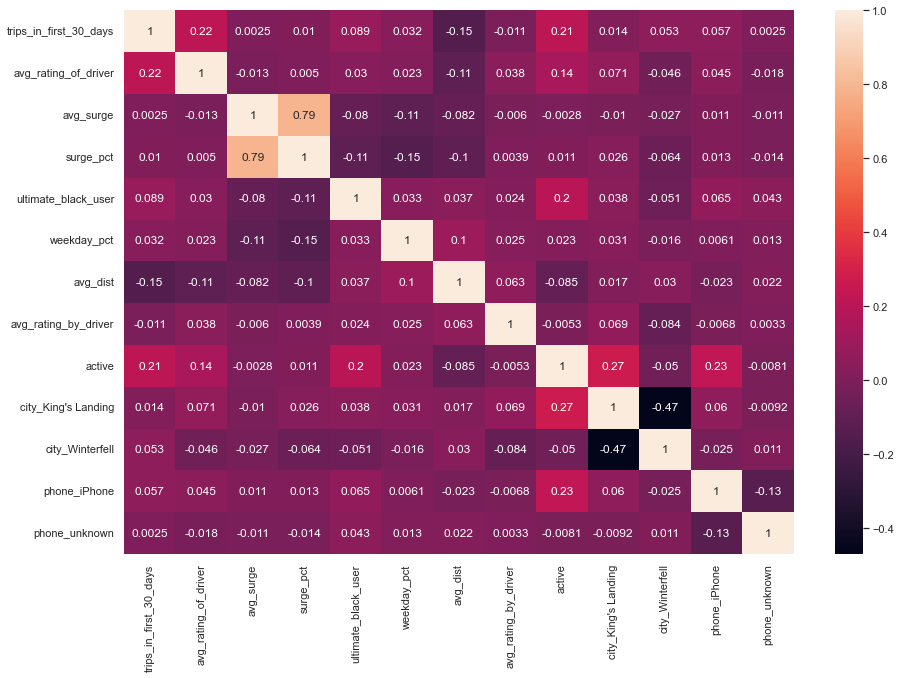

In [59]:
# look at the correlations
plt.figure(figsize=(15,10))
sns.heatmap(users_data_numeric.corr(), annot=True);

As seen above there are some positive correlation between some features and the target. Such as:
- phone_iphone
- city_King's Landing
- ultimate_black_user
- trips_in_first_30_days

There are 2 feature with high multicollinearity: 
- avg_surge
- surge_prc

Therefore we will drop one of them.

In [60]:
users_data_numeric = users_data_numeric.drop(['surge_pct'],axis=1)
users_data_numeric.head()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active,city_King's Landing,city_Winterfell,phone_iPhone,phone_unknown
0,4,4.7,1.10,1,46.2,3.67,5.0,1,1,0,1,0
1,0,5.0,1.00,0,50.0,8.26,5.0,0,0,0,0,0
2,3,4.3,1.00,0,100.0,0.77,5.0,0,0,0,1,0
3,9,4.6,1.14,1,80.0,2.36,4.9,1,1,0,1,0
4,14,4.4,1.19,0,82.4,3.13,4.9,0,0,1,0,0


### Feature Selection

As we have seen above we already somehow know which features have the most corroletion with the target. But lets calculate the scores by fitting the features into SelectKBest model.

                      Name        Score
0   trips_in_first_30_days  4980.794838
1      city_King's Landing  1907.104830
2                 avg_dist  1202.399997
3      ultimate_black_user   875.906365
4             phone_iPhone   550.829646
5     avg_rating_of_driver   538.400735
6              weekday_pct   307.231833
7          city_Winterfell    48.368846
8            phone_unknown     4.120287
9     avg_rating_by_driver     0.116031
10               avg_surge     0.000069


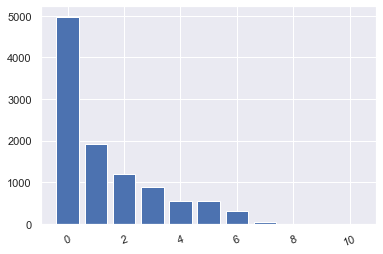

In [61]:
# caclculate the best features
# prepare and divide the data to test and train
X_train, X_test, y_train, y_test = prepare_train_test (users_data_numeric,'active')

# fit the data to the feature selection model
X_train_fs, X_test_fs, fs = select_features(X_train, y_train,X_test)
calculate_scores(fs,X_train)

The scores confirm that:
- avg_surge,avg_rating_by_driver,phone_unknown,city_Winterfell

have the least impact on our target. Therefore we can drop them safely.

In [62]:
#users_data_numeric = users_data_numeric.drop(['avg_surge','avg_rating_by_driver','phone_unknown','city_Winterfell'], axis = 1)
users_data_numeric.head()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active,city_King's Landing,city_Winterfell,phone_iPhone,phone_unknown
0,4,4.7,1.10,1,46.2,3.67,5.0,1,1,0,1,0
1,0,5.0,1.00,0,50.0,8.26,5.0,0,0,0,0,0
2,3,4.3,1.00,0,100.0,0.77,5.0,0,0,0,1,0
3,9,4.6,1.14,1,80.0,2.36,4.9,1,1,0,1,0
4,14,4.4,1.19,0,82.4,3.13,4.9,0,0,1,0,0


Last step is to scale the data to make sure the features are ditributed in an equal way.

In [63]:
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled_df = pd.DataFrame(X_train_scaled,columns=X_train.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled,columns=X_test.columns)

In [64]:
X_train_scaled_df

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,city_King's Landing,city_Winterfell,phone_iPhone,phone_unknown
0,0.000000,0.00,0.000000,0.0,1.000,0.015184,1.00,1.0,0.0,0.0,0.0
1,0.000000,1.00,0.000000,0.0,1.000,0.043795,1.00,0.0,0.0,0.0,0.0
2,0.642857,0.98,0.000000,0.0,0.667,0.032501,0.96,0.0,1.0,1.0,0.0
3,0.000000,0.00,0.000000,0.0,1.000,0.082821,1.00,0.0,0.0,0.0,0.0
4,0.071429,0.00,0.000000,1.0,1.000,0.008031,1.00,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
32868,0.071429,0.00,0.000000,0.0,0.000,0.055214,1.00,0.0,1.0,1.0,0.0
32869,0.000000,1.00,0.000000,0.0,0.000,0.043167,0.00,0.0,0.0,0.0,0.0
32870,0.428571,0.96,0.000000,1.0,0.286,0.029113,0.92,0.0,1.0,0.0,0.0
32871,0.285714,0.90,0.004211,1.0,0.364,0.031748,0.90,1.0,0.0,1.0,0.0


### Modeling

Confusion Matrix for: Logistic Regression
[[9024 1498]
 [2849 2821]]
              precision    recall  f1-score   support

           0       0.76      0.86      0.81     10522
           1       0.65      0.50      0.56      5670

    accuracy                           0.73     16192
   macro avg       0.71      0.68      0.69     16192
weighted avg       0.72      0.73      0.72     16192

Total elapsed time to fit is: 0.0781 (s)
Total elapsed time to predict is: 0.0011 (s)
Overal elapsed time to predict is: 0.0791 (s)


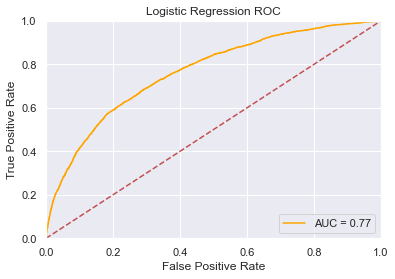

Confusion Matrix for: Random Forest
[[8664 1858]
 [2003 3667]]
              precision    recall  f1-score   support

           0       0.81      0.82      0.82     10522
           1       0.66      0.65      0.66      5670

    accuracy                           0.76     16192
   macro avg       0.74      0.74      0.74     16192
weighted avg       0.76      0.76      0.76     16192

Total elapsed time to fit is: 2.2074 (s)
Total elapsed time to predict is: 0.2466 (s)
Overal elapsed time to predict is: 2.4540 (s)


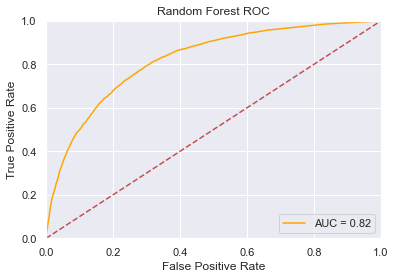

Confusion Matrix for: KNN
[[8622 1900]
 [2151 3519]]
              precision    recall  f1-score   support

           0       0.80      0.82      0.81     10522
           1       0.65      0.62      0.63      5670

    accuracy                           0.75     16192
   macro avg       0.72      0.72      0.72     16192
weighted avg       0.75      0.75      0.75     16192

Total elapsed time to fit is: 0.1434 (s)
Total elapsed time to predict is: 0.7602 (s)
Overal elapsed time to predict is: 0.9036 (s)


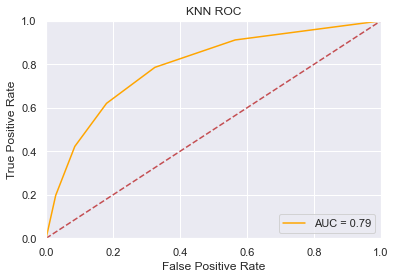

Confusion Matrix for: Decesion Tree Model
[[8169 2353]
 [2322 3348]]
              precision    recall  f1-score   support

           0       0.78      0.78      0.78     10522
           1       0.59      0.59      0.59      5670

    accuracy                           0.71     16192
   macro avg       0.68      0.68      0.68     16192
weighted avg       0.71      0.71      0.71     16192

Total elapsed time to fit is: 0.0845 (s)
Total elapsed time to predict is: 0.0033 (s)
Overal elapsed time to predict is: 0.0878 (s)


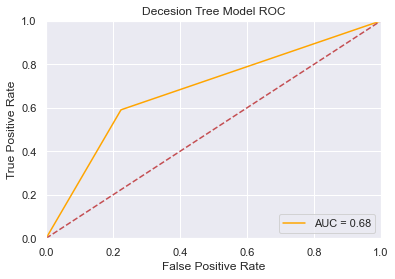

Confusion Matrix for: GB Modeling
[[9147 1375]
 [1990 3680]]
              precision    recall  f1-score   support

           0       0.82      0.87      0.84     10522
           1       0.73      0.65      0.69      5670

    accuracy                           0.79     16192
   macro avg       0.77      0.76      0.77     16192
weighted avg       0.79      0.79      0.79     16192

Total elapsed time to fit is: 1.9473 (s)
Total elapsed time to predict is: 0.0261 (s)
Overal elapsed time to predict is: 1.9734 (s)


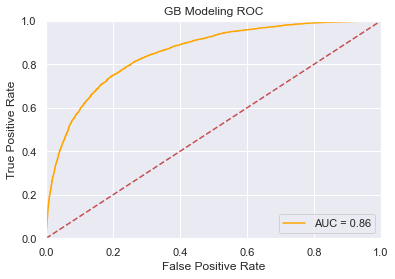

In [65]:
log_reg_model = LogisticRegression()

rf_model = RandomForestClassifier()

knn_model = KNeighborsClassifier()

dt_model = DecisionTreeClassifier()

gbs_model = GradientBoostingClassifier()


summary = {}

#svm_model = SVC()

model_names = ['Logistic Regression','Random Forest','KNN','Decesion Tree Model','GB Modeling']
models = [log_reg_model,rf_model,knn_model,dt_model,gbs_model]
count = 0

for model in models:
    result = apply_mode(X_train_scaled_df,y_train,X_test_scaled_df,y_test,model,model_names[count])
    summary[model_names[count]] = result
    count = count+1

In [66]:
print("{:<20}{:<10}{:<10}{:<10}{:<10}".format('Model', 'Accuracy', 'F1-score', 'Precision','Recall'))
for model_name, result in summary.items():
    print("{:<20}{:<10}{:<10}{:<10}{:<10}".format(model_name, round(result[0], 3),round(result[1], 3),round(result[2], 3),round(result[3], 3)))

Model               Accuracy  F1-score  Precision Recall    
Logistic Regression 0.732     0.721     0.653     0.498     
Random Forest       0.762     0.761     0.664     0.647     
KNN                 0.75      0.748     0.649     0.621     
Decesion Tree Model 0.711     0.711     0.587     0.59      
GB Modeling         0.792     0.789     0.728     0.649     


### The best model is Gradient Boosting Classifier with highest accuracy of 79%. 
It also had high precision and recall for both classes. One caveat here is Gradient Boosting Models can be prone to overfitting; to refine this model, we would use cross-validation to fine-tune the hyperparameters of the model as below.

In [78]:
param_grid = [{'n_estimators':[10, 50, 100, 200],'learning_rate':[0.0001, 0.001, 0.01, 0.1, 1.0],'subsample':[0.5, 0.7, 1.0],'max_depth': [3, 7, 9]}]
model = GradientBoostingClassifier()
apply_gridSearch(model,param_grid,X_train_scaled,y_train,'Granient Boosting')

The best score for the search grid for Granient Boosting is 0.78 
The best parameters for the search grid for Granient Boosting is {'learning_rate': 0.01, 'max_depth': 9, 'n_estimators': 200, 'subsample': 1.0} 
Total elapsed time is: 114.8013 (s)


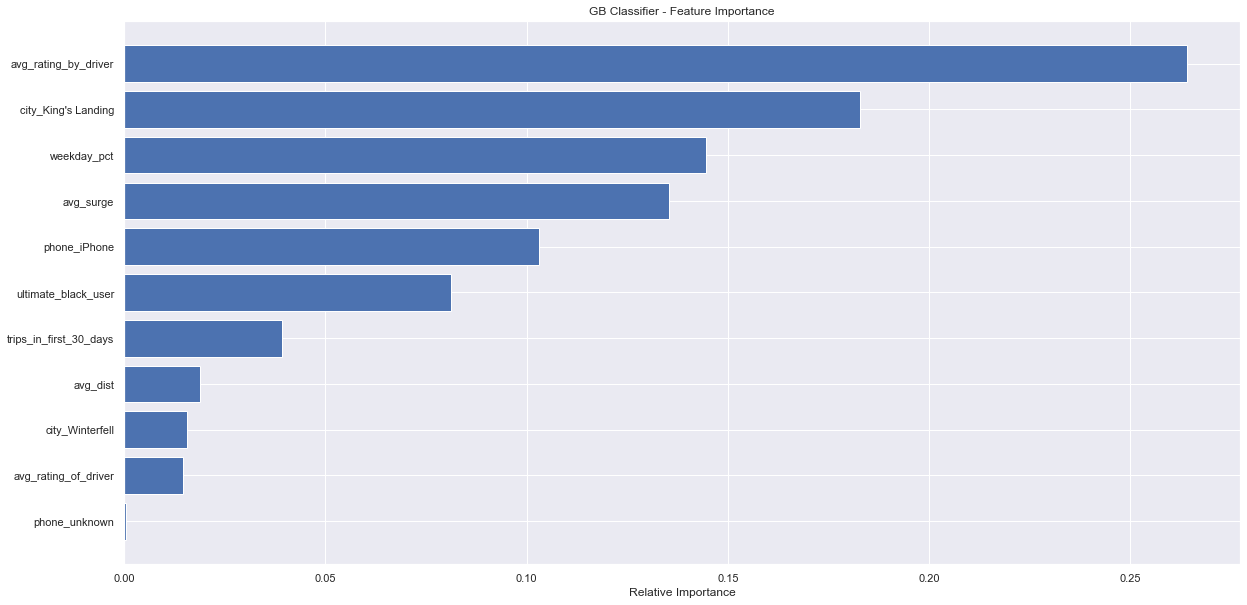

In [77]:
# Lets plot the features importance in this model
plot_feature_importance(gbs_model, 'GB Classifier', X_test_scaled_df)

Top important features are:
- avg_rating_by_driver
- city_King's Landing
- weekday_pct
- ultimate_black_user
- avg_surge
- phone_iphon
- trips_in_first_30_days

## 3-3) Business Recommendation
#### Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long term rider retention


By having these insights, Ultimate can have different expereiment with the highest features impact on users retention to increase the rate. We have some recommendations:

* 1) Try to attract more customers from King's Landing city, by offering promotions
* 2) Encourge the customers to use the Ultimate app during the weekdays, by offering discounts.
* 3) Encourge the customers to become ultime_black by offering promotions
